<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Keras-ResNet50-Imagenet" data-toc-modified-id="Keras-ResNet50-Imagenet-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Keras ResNet50 Imagenet</a></span></li><li><span><a href="#Requesting-Prediction-From-Simple-Service" data-toc-modified-id="Requesting-Prediction-From-Simple-Service-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Requesting Prediction From Simple Service</a></span></li><li><span><a href="#Service---Redis-Message-Queue" data-toc-modified-id="Service---Redis-Message-Queue-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Service - Redis Message Queue</a></span><ul class="toc-item"><li><span><a href="#Redis-Installation" data-toc-modified-id="Redis-Installation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Redis Installation</a></span></li></ul></li></ul></div>

In [1]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array

# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib,keras,tensorflow

Using TensorFlow backend.
/Users/mingyuliu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mingyuliu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mingyuliu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/mingyuliu/anaconda3/lib/python3.6/sit

Ethen 2019-08-24 15:16:29 

CPython 3.6.4
IPython 7.7.0

numpy 1.17.0
pandas 0.25.0
sklearn 0.21.2
matplotlib 3.1.1
keras 2.2.2
tensorflow 1.13.1


# Keras ResNet50 Imagenet

This section shows some minimal steps to load some pre-trained image models that have been trained on imagenet, and using these pre-trained models to classify new images.

In [2]:
from keras.applications import ResNet50

model = ResNet50(weights='imagenet')
model

Instructions for updating:
Colocations handled automatically by placer.


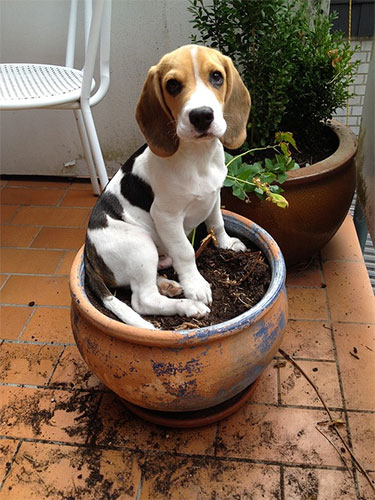

In [3]:
image_path = os.path.join('images', 'dog.jpg')
image = Image.open(image_path)
image

Instead of using the raw image that we've loaded, we need to do some preprocessing such as perform the same preprocessing that was done to the images that the model was trained on and even though we only have 1 image, we expand it so that it looks like we have a batch of image (a batch size of 1) as this is what the model's predict function expects.

In [4]:
def prepare_image(image, target):
    """
    Preprocess the pillow image prior to converting to a numpy array which
    the model accepts for inferencing.

    Parameters
    ----------
    image :
        Pillow image.

    target :
        Target size of the image. Will resize the input image to the specified size.
        e.g. for Imagenet Resnet50, the expected target size is 224, 224

    Returns
    -------
    image_array : 4d ndarray [batch size, width, height, channel]
    """
    image = image.resize(target)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return imagenet_utils.preprocess_input(image)


target = 224, 224
clean_image = prepare_image(image, target)
clean_image.shape

(1, 224, 224, 3)

The next code chunk uses to model to generate the predicted class and we then use the `decode_predictions` helper function to decode the results into a list of tuples (imagenet class, label, probability).

In [5]:
top = 5
raw_prediction = model.predict(clean_image)
prediction = imagenet_utils.decode_predictions(raw_prediction, top)
prediction

[[('n02088364', 'beagle', 0.98777544),
  ('n03991062', 'pot', 0.0020967808),
  ('n02113186', 'Cardigan', 0.0013517038),
  ('n02089867', 'Walker_hound', 0.0012711132),
  ('n02101388', 'Brittany_spaniel', 0.0010085133)]]

# Requesting Prediction From Simple Service

https://blog.keras.io/building-a-simple-keras-deep-learning-rest-api.html

Submitting our request to the service and programmatically parse the response. We need to first start the app locally for this section to work.

```python
python flask_deploy/simple/app.py
```

In [33]:
import requests

# initialize the Keras REST API endpoint URL along with the input
# image path
KERAS_REST_API_URL = 'http://localhost:5000/predict'
IMAGE_PATH = os.path.join('images', 'dog.jpg')

# load the input image and construct the payload for the request
with open(IMAGE_PATH, 'rb') as f:
    image = f.read()

params = {'top': 3}
files = {'image': image}
response = requests.post(KERAS_REST_API_URL, params=params, files=files)
response

<Response [200]>

In [34]:
if response.status_code == 200:
    predictions = response.json()['predictions']
    for i, result in enumerate(predictions, 1):
        print('top{} - {}: {:.3f}'.format(i, result['label'], result['prob']))

top1 - beagle: 0.988
top2 - pot: 0.002


In [35]:
%%timeit
response = requests.post(KERAS_REST_API_URL, params=params, files=files)

230 ms ± 3.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Service - Redis Message Queue

https://www.pyimagesearch.com/2018/01/29/scalable-keras-deep-learning-rest-api/

## Redis Installation

https://redis.io/download

```bash
# download and install redis
wget http://download.redis.io/releases/redis-5.0.5.tar.gz
tar xzf redis-5.0.5.tar.gz
cd redis-5.0.5
make

# launch the redis server
src/redis-server

# in another terminal test to make sure the server is up and running
src/redis-cli ping
# we should see PONG as the response
```


Redis Hands-On Introduction: https://realpython.com/python-redis/

In [30]:
files = {'image': image}
response = requests.post(KERAS_REST_API_URL, files=files)
response

<Response [200]>

In [32]:
%%timeit
response = requests.post(KERAS_REST_API_URL, files=files)

153 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
import redis

redis_client = redis.Redis()
redis_client

Redis<ConnectionPool<Connection<host=localhost,port=6379,db=0>>>

Prior to storing our image in a data store, we will serialize it. In the following code chunk, We encode our image as strings using base64 encoding.

- https://stackoverflow.com/questions/43310681/how-to-convert-python-numpy-array-to-base64-output/43311213
- https://www.quora.com/Whats-the-purpose-of-using-Base64-to-encode-an-image-before-uploading
- https://bunnycdn.com/blog/why-optimizing-your-images-with-base64-is-almost-always-a-bad-idea/amp/

In [11]:
import json
import uuid
import base64

image_c_ordered = clean_image.copy(order='C')
image_shape = image_c_ordered.shape
image_dtype = image_c_ordered.dtype
encoded_image = base64.b64encode(image_c_ordered).decode('utf-8')

payload = {'id': str(uuid.uuid4()), 'image': encoded_image}

- https://redis.io/commands/rpush
- https://redis.io/commands/lrange
- https://redis.io/commands/ltrim

In [12]:
IMAGE_QUEUE = 'image_queue'

# push the image to redis
# the rpush expects byte, string or number
redis_client.rpush(IMAGE_QUEUE, json.dumps(payload))

3

In [13]:
# we retrieve the image from redis, and decode the image back
queued_image = redis_client.lrange(IMAGE_QUEUE, 0, 0)
payload = json.loads(queued_image[0].decode('utf-8'))

In [14]:
encoded_image = payload['image']
decoded_image = base64.decodebytes(encoded_image.encode('utf-8'))
image = np.frombuffer(decoded_image, dtype=image_dtype).reshape(*image_shape)
image.shape

(1, 224, 224, 3)

In [15]:
def score_image(model, image, top):
    raw_prediction = model.predict(image)
    decoded_predictions = imagenet_utils.decode_predictions(raw_prediction, top)

    predictions = []
    for imagenet_id, label, prob in decoded_predictions[0]:
        prediction = {'label': label, 'prob': round(float(prob), 4)}
        predictions.append(prediction)

    return predictions 

In [17]:
redis_client.ltrim(IMAGE_QUEUE, 1, -1)

True

In [18]:
redis_client.set(payload['id'], json.dumps(predictions))

True

In [19]:
output = redis_client.get(payload['id']).decode('utf-8')
output

'[{"label": "beagle", "prob": 0.9878}, {"label": "pot", "prob": 0.0021}, {"label": "Cardigan", "prob": 0.0014}, {"label": "Walker_hound", "prob": 0.0013}, {"label": "Brittany_spaniel", "prob": 0.001}]'

In [20]:
redis_client.delete(payload['id'])

1